In [ ]:
# Import required Python packages

import boto3
from datetime import datetime
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.jackhmmer_job import JackhmmerJob
from batchfold.openfold_job import OpenFoldJob
from batchfold.alphafold2_job import AlphaFold2Job
from batchfold.batchfold_target import BatchFoldTarget
from batchfold.mmseqs2_job import MMseqs2Job
import matplotlib.pyplot as plt
from nbhelpers import nbhelpers
import os
import json
import pandas as pd
import requests

# Get client information
boto_session = boto3.session.Session()
batch_environment = BatchFoldEnvironment(boto_session = boto_session)

S3_BUCKET = batch_environment.default_bucket
print(f" S3 bucket name is {S3_BUCKET}")

s3 = boto_session.client("s3")

In [ ]:
targets = pd.read_csv("cameo_benchmarking_targets.csv", header=0)    

In [ ]:
import requests 
from Bio import SeqIO
from io import StringIO

for _, row in targets.iterrows():
    print(row["SEQ_ID"])
    target = BatchFoldTarget(target_id=row["SEQ_ID"], s3_bucket=S3_BUCKET, boto_session=boto_session)    
    fasta_string = requests.get(row["SEQ_URL"]).content.decode("utf-8")
    with StringIO(fasta_string) as fasta:
        for record in SeqIO.parse(fasta, "fasta"):
            target.add_sequence(
                seq_id=row["SEQ_ID"],
                seq=str(record.seq),
                description=record.description
            )
    
    job_name = target.target_id + "_MMseqs2Job_" + datetime.now().strftime("%Y%m%d%s")
    mmseqs2_job = MMseqs2Job(
            job_name = job_name,
            target_id = target.target_id,
            fasta_s3_uri = target.get_fasta_s3_uri(),
            output_s3_uri = target.get_msas_s3_uri(),
            boto_session = boto_session,
            cpu = 64,
            memory = 500
        )

    job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
    jackhmmer_job = JackhmmerJob(
        job_name = job_name,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        output_s3_uri = target.get_msas_s3_uri(),
        boto_session = boto_session,
        cpu = 16,
        memory = 32
    )

    job_name = target.target_id + "_Jackhmmer_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
    jackhmmer_openfold_job = OpenFoldJob(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer/",
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        config_preset = "finetuning_ptm",
        openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
        save_outputs = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )

    job_name = target.target_id + "_Mmseq2_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
    mmseqs2_openfold_job = OpenFoldJob(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri()+"/mmseqs2/",
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        config_preset = "finetuning_ptm",
        openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
        save_outputs = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )    

    job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
    alphafold2_job = AlphaFold2Job(
        job_name = job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer",
        output_s3_uri = target.get_predictions_s3_uri() + "/" + job_name,
        use_precomputed_msas = True,
        model_preset = "monomer_ptm",    
        benchmark = True,
        cpu = 4,
        memory = 15, # Why not 16? ECS needs about 1 GB for container services
        gpu = 1
    )    

    jackhmmer_submission = batch_environment.submit_job(jackhmmer_job, job_queue_name="GravitonOnDemandJobQueue")
    mmseqs2_submission = batch_environment.submit_job(mmseqs2_job, job_queue_name="GravitonOnDemandJobQueue")

    jackhmmer_openfold_submission = batch_environment.submit_job(jackhmmer_openfold_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])
    mmseqs2_openfold_submission = batch_environment.submit_job(mmseqs2_openfold_job, job_queue_name="G4dnJobQueue", depends_on=[mmseqs2_submission])
    alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])    



In [ ]:
%%bash
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
g++ -O3 -ffast-math -lm -o TMscore TMscore.cpp

In [ ]:
results = {}
for _, row in targets.iterrows():
    target_id = row["SEQ_ID"]
    print(target_id)
    target_results = {}
    # target_results["target_id"] = target_id
    target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
    os.makedirs(f"/Users/bloyal/batch-protein-folding/notebooks/data/{target.target_id}/", exist_ok=True)

    # Get experimental pdb
    pdb_string = requests.get(row["PDB_URL"]).content.decode("utf-8")
    experimental_pdb = f"data/{target.target_id}/{target_id}.pdb"
    with open(experimental_pdb, "w") as f:
        f.write(pdb_string)

    try:
        # Mmseqs2 OpenFold
        ## Get .pdb
        mmseqs2_of_pdb = f"data/{target.target_id}/{target.target_id}_Mmseq2_OpenFold_finetuning_ptm_relaxed.pdb"
        s3.download_file(S3_BUCKET, f"{target.target_id}/predictions/{target.get_last_job_name(job_type='Mmseq2_OpenFold')}/{target.target_id}_finetuning_ptm_relaxed.pdb", mmseqs2_of_pdb)

        ## Get timings
        of_timings = nbhelpers.get_openfold_timings_for_job_name(batch_environment, target.get_last_job_name(job_type='Mmseq2_OpenFold'), prefix="mmseqs2_openfold_")
        target_results.update(of_timings)

        ## Calculate TS_GDT
        mmseqs2_of_score_results = nbhelpers.run_tmscore(mmseqs2_of_pdb, experimental_pdb)
        print(f"MMseqs2 OpenFold TS_GDT Score: {mmseqs2_of_score_results['gdt']}")
        target_results.update({"mmseqs2_openfold_gdt": mmseqs2_of_score_results['gdt']})
    except:
        None

    try:
        # Jackhmmer OpenFold
        ## Get .pdb
        jackhmmer_of_pdb = f"data/{target.target_id}/{target.target_id}_Jackhmmer_OpenFold_finetuning_ptm_relaxed.pdb"
        s3.download_file(S3_BUCKET, f"{target.target_id}/predictions/{target.get_last_job_name(job_type='Jackhmmer_OpenFold')}/{target.target_id}_finetuning_ptm_relaxed.pdb", jackhmmer_of_pdb)

        ## Get timings
        of_timings = nbhelpers.get_openfold_timings_for_job_name(batch_environment, target.get_last_job_name(job_type='Jackhmmer_OpenFold'), prefix="jackhmmer_openfold_")
        target_results.update(of_timings)

        ## Calculate TS_GDT
        jackhmmer_of_score_results = nbhelpers.run_tmscore(jackhmmer_of_pdb, experimental_pdb)
        print(f"Jackhmmer OpenFold TS_GDT Score: {jackhmmer_of_score_results['gdt']}")
        target_results.update({"jackhmmer_openfold_gdt": jackhmmer_of_score_results['gdt']})            
    except:
        None

    try:
        # AlphaFold2
        ## Get .pdb
        af_pdb = f"data/{target.target_id}/ranked_0.pdb"
        s3.download_file(S3_BUCKET, f"{target.target_id}/predictions/{target.get_last_job_name(job_type='AlphaFold2')}/ranked_0.pdb", af_pdb)

        ## Get timings
        response = s3.get_object(Bucket=S3_BUCKET, Key=f"{target.target_id}/predictions/{target.get_last_job_name(job_type='AlphaFold2')}/timings.json")
        body = response['Body'].read()
        af_timings = json.loads(body)
        target_results.update(af_timings)

        ## Calculate TS_GDT
        af_score_results = nbhelpers.run_tmscore(af_pdb, experimental_pdb)
        print(f"AlphaFold2 TS_GDT Score: {af_score_results['gdt']}")
        target_results.update({"alphafold2_gdt": af_score_results['gdt']})            
    except:
        None         

    results[target_id] = target_results

results_df = pd.DataFrame.from_dict(results, orient='index')
# output = pd.merge(targets, results_df, how='left', on='x1')

In [ ]:
output_df = targets.merge(results_df, how="left", left_on="SEQ_ID", right_index = True)
output_df.to_csv("cameo_results_220810.csv")

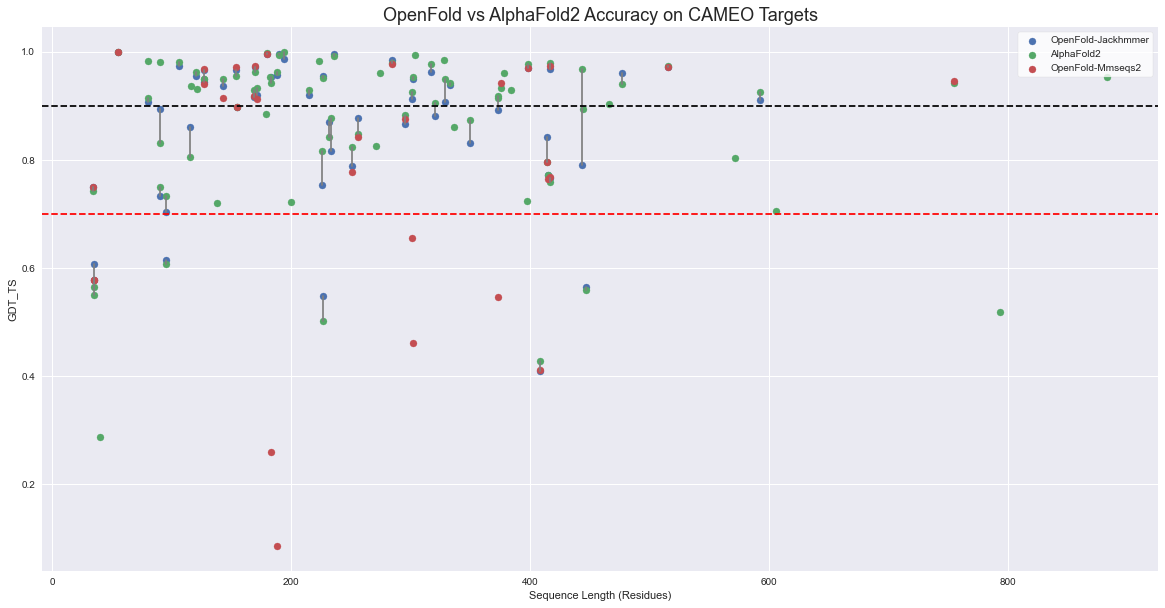

In [5]:
#Plot GDT scores vs experimental structures in PDB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = pd.read_csv("/Users/bloyal/batch-protein-folding/notebooks/cameo_results_220810.csv")


plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,10))

x = results["SEQ_LENGTH"]
y1 = results["jackhmmer_openfold_gdt"]
y2 = results["alphafold2_gdt"]
y3 = results["mmseqs2_openfold_gdt"]
ax.scatter(x, y1, label="OpenFold-Jackhmmer")
ax.scatter(x, y2, label="AlphaFold2")
ax.scatter(x, y3, label="OpenFold-Mmseqs2")

X_line_coords = np.array([
    results["SEQ_LENGTH"],
    results["SEQ_LENGTH"]
])
Y_line_coords = np.array([
    results["jackhmmer_openfold_gdt"],
    results["alphafold2_gdt"]
])
ax.plot(X_line_coords, Y_line_coords, color="gray")

ax.axhline(0.9, color="black", linestyle="--")
ax.axhline(0.7, color="red", linestyle="--")
ax.legend(frameon=True, facecolor="white")
ax.set_xlabel("Sequence Length (Residues)")
ax.set_ylabel("GDT_TS")
plt.title("OpenFold vs AlphaFold2 Accuracy on CAMEO Targets", fontsize=18)
plt.show()

# for i in range(1,6):
#     results[f"alphafold_time_{i}"] = results[f"alphafold_time_process_features_model_{i}_ptm_pred_0"] + results[f"alphafold_time_predict_and_compile_model_{i}_ptm_pred_0"] + results[f"alphafold_time_relax_model_{i}_ptm_pred_0"]

# results["alphafold_time"] = results["alphafold_time_1"] + results["alphafold_time_2"]+ results["alphafold_time_3"]+ results["alphafold_time_4"]+ results["alphafold_time_5"]
# results["openfold_time"] = results["openfold_inference_time"] + results["openfold_relaxation"]
# import matplotlib.pyplot as plt
# import numpy as np

# plt.style.use('seaborn')

# fig, ax = plt.subplots(figsize=(20,10))

# x = results["seq_length"]
# y1 = results["alphafold_time_1"]
# y2 = results["alphafold_time_2"]
# y3 = results["alphafold_time_3"]
# y4 = results["alphafold_time_4"]
# y5 = results["alphafold_time_5"]
# y6 = results["openfold_time"]

# width = 5

# ax.bar(x + width/2, y1, width, label="AlphaFold2 Model 1")
# ax.bar(x + width/2, y2, width, bottom=y1, label="AlphaFold2 Model 2")
# ax.bar(x + width/2, y3, width, bottom=y1+y2, label="AlphaFold2 Model 3")
# ax.bar(x + width/2, y4, width, bottom=y1+y2+y3, label="AlphaFold2 Model 4")
# ax.bar(x + width/2, y5, width, bottom=y1+y2+y3+y4, label="AlphaFold2 Model 5")
# ax.bar(x - width/2, y6, width, label="OpenFold")

# ax.legend(frameon=True, facecolor="white")
# ax.set_xlabel("Sequence Length (Residues)")
# ax.set_ylabel("Time (sec)")
# plt.title("OpenFold vs AlphaFold2 Run Times on CAMEO Targets (By Model)", fontsize=18)
# plt.show()